## Projected Gradient Descent (PGD) Attack

#### modules and model

In [1]:
import foolbox
import keras
import numpy as np
from keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.imagenet_utils import decode_predictions

/Users/eddiebedada/anaconda3/lib/python3.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/eddiebedada/anaconda3/lib/python3.7/site-packages/h5py/__init__.py:68: UserWarning: h5py is running against HDF5 1.10.4 when it was built against 1.8.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


Let's start by insantiating the model and introducing a preprocessing task.

In [2]:
keras.backend.set_learning_phase(0)
kmodel = ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.



Next up, we will use a sample image and its label from the imagenet dataset.

In [3]:
from PIL import Image

filename = './data/warplane2.jpg'
label=895 # https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

original = load_img(filename, target_size=(224, 224))
numpy_image = img_to_array(original)
original_img_batch = np.expand_dims(numpy_image, axis=0)

print('image batch size', original_img_batch.shape)


image batch size (1, 224, 224, 3)


#### Plot original image

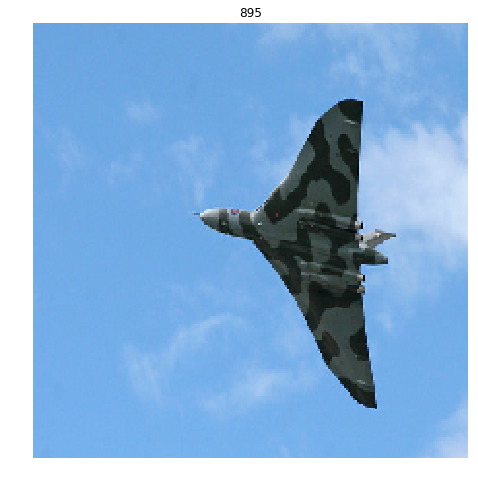

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(np.uint8(original_img_batch[0]))
plt.title(label)
plt.axis('off')
plt.show()

### Prediction on the original image

In [5]:
orignal_img_prediction = kmodel.predict_on_batch(original_img_batch)
original_img_label = decode_predictions(orignal_img_prediction )

print(original_img_label[0])

[('n04552348', 'warplane', 0.8916511), ('n04592741', 'wing', 0.05332023), ('n04266014', 'space_shuttle', 0.023437275), ('n04008634', 'projectile', 0.011651035), ('n02690373', 'airliner', 0.006808288)]


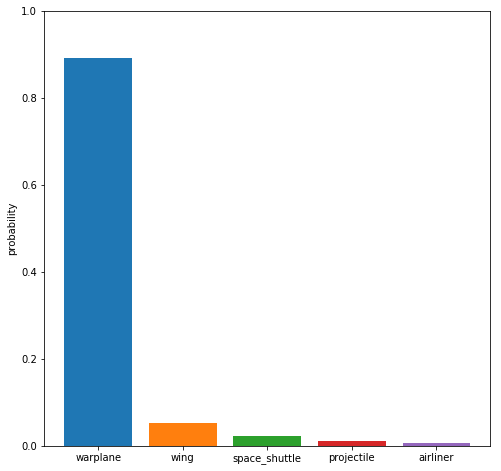

In [6]:
plt.figure(figsize=(8,8))
for i in enumerate(original_img_label[0]):
    name,org_score = i[1][1:3]
    plt.bar(name,org_score)
    plt.ylim(0,1)
    plt.ylabel('probability')
    

The model classified the image as a warplane with 89% confidence.

### Applying the Attack

Steps:
    - First, call the FGMS attack
    - Second, get the gradient of the model 
    - Third, introduce the attack to the image.


In [38]:
from foolbox.distances import Linfinity 
from foolbox.criteria import Misclassification
attack = foolbox.attacks.PGD(fmodel, 
                             criterion=Misclassification(), 
                             distance=Linfinity)

In [29]:
adversarial = attack(numpy_image[:, :, ::-1], label=895)

# attack = LBFGSAttack(model=fmodel, 
#                      criterion=TargetClassProbability(812, p=.5))

# adversarial = attack(img_arr[:, :, ::-1], label)


In [30]:
difference = adversarial[:, :, ::-1] - numpy_image
difference[0:1,0:14]

array([[[-0.18034363, -0.18034363, -0.18034363],
        [-0.18034363, -0.18034363, -0.18034363],
        [ 0.01202393, -0.15629578, -0.18034363],
        [-0.18034363, -0.18034363, -0.18034363],
        [-0.0480957 , -0.15631104, -0.18034363],
        [-0.0480957 , -0.0480957 ,  0.01202393],
        [-0.08416748, -0.07214355, -0.08416748],
        [-0.18034363, -0.18034363, -0.18034363],
        [ 0.18034363, -0.16833496, -0.10821533],
        [-0.18034363, -0.18034363, -0.18034363],
        [-0.13226318, -0.18034363, -0.03607178],
        [ 0.10821533,  0.10821533,  0.16833496],
        [ 0.        , -0.03607178, -0.07214355],
        [ 0.15631104,  0.18034363,  0.18034363]]], dtype=float32)

The array shown above is the first 15 values added to the original image by the attack to create an adverserial example. To visualize the values, a little bit of agumentation is needed.

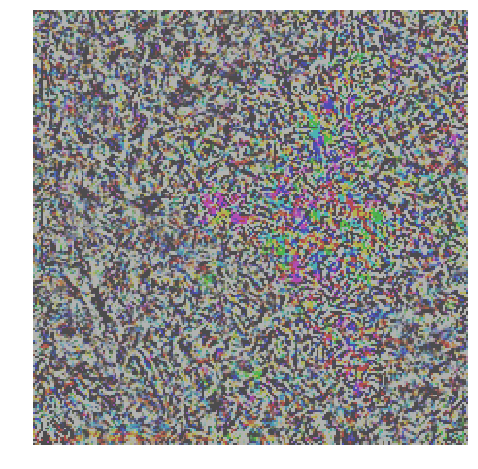

In [31]:
plt.figure(figsize=(8,8))
agumentated_adv = difference / abs(difference).max() * 0.2 + 0.5
plt.imshow(agumentated_adv)
plt.axis('off')
plt.show()

### Mean Perturbation

In [32]:
from foolbox.distances import MeanSquaredDistance as MSD

# bounds = The min: 0 and max: 255
bounds = adversarial.min(), adversarial.max()

distance_arr_adv= MSD(reference=original_img_batch, 
                      other=adversarial, 
                      bounds=bounds)

print(distance_arr_adv)

normalized MSE = 1.10e-01


#### Plot the adversarial example

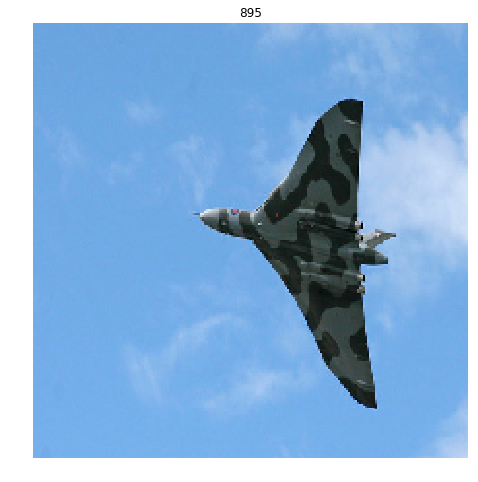

In [33]:
plt.figure(figsize=(8,8))
plt.imshow(adversarial[:, :, ::-1]/255)
plt.title(label)
plt.axis('off')
plt.show()

### Side by side view

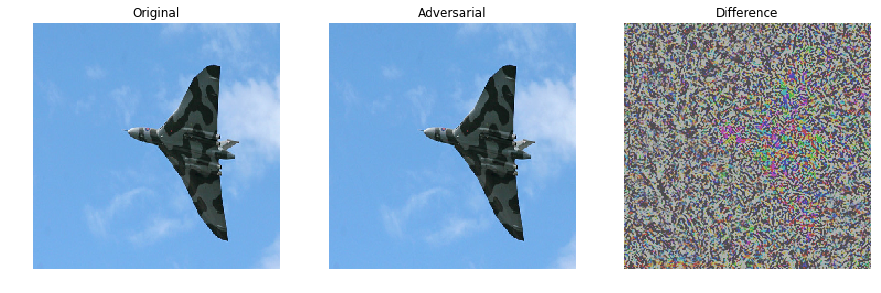

In [34]:
%matplotlib inline

plt.figure(figsize=(15,15))

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(numpy_image / 255) 
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow(adversarial[:, :, ::-1] / 255)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - numpy_image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

 ### Prediction on the adversarial

Let's use the imagenet model and predict on both the original image and the adverserial example. 
First, change each of the images to a batch format.

In [35]:
advesarial_img_batch = np.expand_dims(adversarial, axis=0)
advesarial_img_prediction = kmodel.predict_on_batch(advesarial_img_batch)
advesarial_img_label = decode_predictions(advesarial_img_prediction)
print(advesarial_img_label)

[[('n04552348', 'warplane', 0.8784649), ('n02687172', 'aircraft_carrier', 0.026180485), ('n04008634', 'projectile', 0.018246343), ('n04044716', 'radio_telescope', 0.017282275), ('n04592741', 'wing', 0.016099485)]]


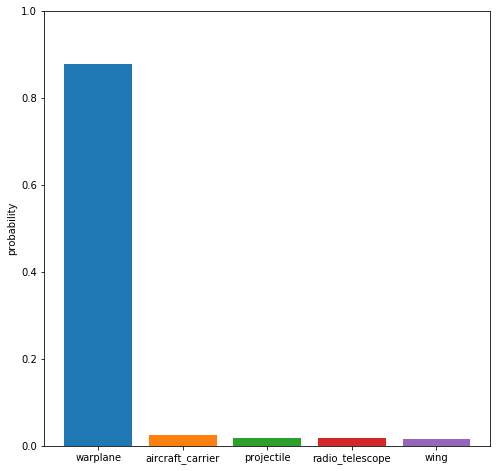

In [36]:
plt.figure(figsize=(8,8))
adv_score_table = []
for i in enumerate(advesarial_img_label[0]):
    name,adv_score = i[1][1:3]
    adv_score_table.append(name)
    adv_score_table.append(adv_score)
    plt.bar(name, adv_score)
    plt.ylim(0,1)
    plt.ylabel('probability')
    

Accordingly, the probability is now down to 45%. that's a 50% decline in confidence.

### References:
    